In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import random

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from hmmlearn import hmm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("whitegrid")

C:\Users\Sonia\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data

In [2]:
df_cus = pd.read_csv('../data/churn_dataset.csv')
df_cus = df_cus.loc[(df_cus.first_order_created_datetime >= "2017-01-01") & (df_cus.last_order_created_datetime < "2018-09-30")]

In [3]:
df_ord = pd.read_csv('../data/order_churn_data.csv')
df_ord = df_ord.merge(df_cus[['customer_db_id', 'completed_orders']], on='customer_db_id', how='left')
df_ord['order_created_datetime'] = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_created_month'] = df_ord.order_created_datetime.dt.month
df_ord['order_created_weekday'] = df_ord.order_created_datetime.dt.weekday

# Filter data

In [4]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])

# number completed orders
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()

df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['frequency_comp'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform('mean')
df_comp['frequency_roll'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform(lambda x: x.expanding().mean())

df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7
df_comp['weeks_since_last_comp'] = df_comp.days_since_last_comp // 7

df_comp['last_order_revenue'] = df_comp.groupby('customer_db_id')['revenue'].shift(1)
df_comp['last_revenue_diff'] = df_comp.revenue - df_comp.last_order_revenue

df_comp['revenue_brutto'] = df_comp.revenue + df_comp.voucher_value

df_comp = df_comp.drop(['next_order_date', 'last_order_date', 'last_order_revenue'], axis=1)

In [5]:
df_comp.sort_values(['customer_db_id', 'order_created_datetime']).head(10)

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,order_created_weekday,order_comp_num,days_until_next_comp,days_since_last_comp,frequency_comp,frequency_roll,weeks_until_next_comp,weeks_since_last_comp,last_revenue_diff,revenue_brutto
291090,GB-W-59043,55e442dfd2cde8c51ec4d4a7,596214c2447709aa7c8b46c7,NaN,NaN,2017-07-09 18:30:00,2017-07-09 19:00:00,NW6 1QD,completed,2017-07-09 12:34:26,...,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.213242
217078,GB-L-89887,5607e33cd4cde8db38c8d25c,58c3babb467709ea298b46ad,51.486661,0.033602,2017-03-12 19:30:00,2017-03-12 20:00:00,SE7 8AY,completed,2017-03-11 08:52:11,...,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.703310
259919,GB-S-33739,56e8cfd2d4cde8b932bae6a9,5904c69c4577094a458b45fb,51.470018,-0.139703,2017-04-30 12:00:00,2017-04-30 12:30:00,SW8 3JD,completed,2017-04-29 18:00:12,...,5,0,45.0,NaN,34.666667,NaN,6.0,NaN,NaN,60.091564
139652,GB-B-78803,56e8cfd2d4cde8b932bae6a9,5941223e457709913d8b45c3,51.470018,-0.139703,2017-06-15 10:00:00,2017-06-15 10:30:00,SW8 3JD,completed,2017-06-14 12:47:10,...,2,1,36.0,45.0,34.666667,45.000000,5.0,6.0,-11.367850,54.067936
195091,GB-H-60995,56e8cfd2d4cde8b932bae6a9,59709c45457709413c8b456a,51.470018,-0.139703,2017-07-21 10:30:00,2017-07-21 11:00:00,SW8 3JD,completed,2017-07-20 13:04:21,...,3,2,23.0,36.0,34.666667,40.500000,3.0,5.0,-9.431380,33.039048
230070,GB-N-24594,56e8cfd2d4cde8b932bae6a9,598fa413457709507a8b45c5,51.470018,-0.139703,2017-08-14 10:00:00,2017-08-14 10:30:00,SW8 3JD,completed,2017-08-13 01:57:55,...,6,3,NaN,23.0,34.666667,34.666667,NaN,3.0,34.090991,61.560095
35799,DE-M-36269,56f87dadd2cde8752f16dc09,59fe0243457709722f8b4635,52.484330,13.441690,2017-11-06 20:00:00,2017-11-06 21:00:00,12045,completed,2017-11-04 19:09:07,...,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.521008
168132,GB-E-75987,56fdc8aad2cde82e6893612c,5ace6b42447709c82f8b4803,51.502691,-0.218643,2018-04-12 10:00:00,2018-04-12 10:30:00,W12,completed,2018-04-11 21:08:34,...,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.488886
297868,GB-X-29500,571b5744d2cde8e833ff595d,58ba8321447709d6158b4592,51.554168,-0.187987,2017-03-05 08:00:00,2017-03-05 10:00:00,NW3 7EB,completed,2017-03-04 09:04:33,...,5,0,29.0,NaN,44.833333,NaN,4.0,NaN,NaN,14.432318
208589,GB-L-01195,571b5744d2cde8e833ff595d,58e1e7b7467709a9528b4612,51.554168,-0.187987,2017-04-03 09:00:00,2017-04-03 11:00:00,NW3 7EB,completed,2017-04-03 07:12:07,...,0,1,28.0,29.0,44.833333,29.000000,4.0,4.0,17.159916,31.592233


# Customer Analysis

In [6]:
cust_sample = random.sample(df_comp.loc[df_comp.completed_orders == 15].customer_db_id.unique().tolist(), 9)
df_cust = df_comp.loc[df_comp.customer_db_id.isin(cust_sample)]

5895a3ed44770940138b4667
58c7b3d04477097e658b4578
58f7e039447709cf728b465c
59028125457709526b8b461a
5954902d457709715e8b45db
598977e145770988528b467f
59fc353944770907268bcbba
59fc393b44770907268e121f
5b218a84c343624b0c6f88e4


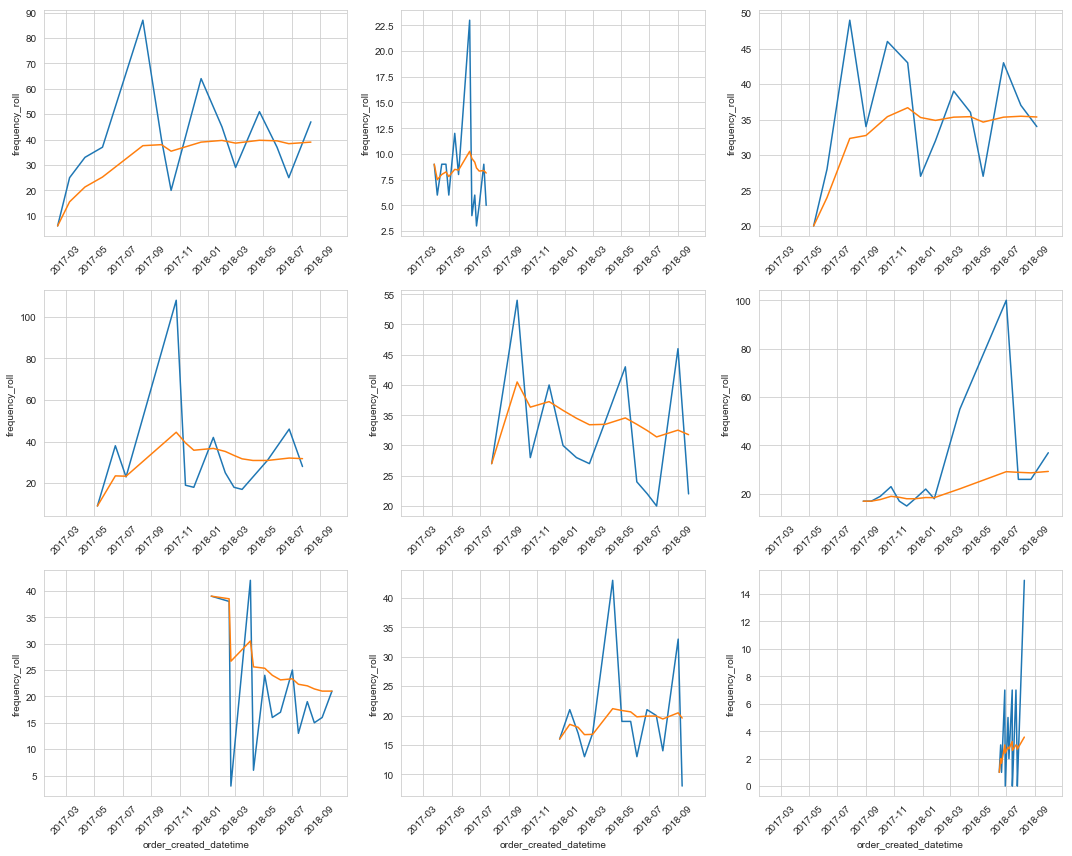

In [7]:
fig, axarr = plt.subplots(3, 3, figsize=(15,12), sharex=True)
i = -1
for idx, (cust_id, df) in enumerate(df_cust.groupby('customer_db_id')):
    print(cust_id)
    if idx % 3 == 0:
        i +=1 
    ax = axarr[i][idx % 3]
    sns.lineplot(data=df, x='order_created_datetime', y='days_since_last_comp', ax=ax)
    sns.lineplot(data=df, x='order_created_datetime', y='frequency_roll', ax=ax)
    
    ax.tick_params(axis='both', which='both', labelbottom=True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_visible(True)

plt.tight_layout()

# Dataset

In [12]:
# df_comp.pivot_table(index=['customer_db_id', 'order_comp_num'])['days_until_next_comp'].unstack().fillna(-1)

In [13]:
cust_2orders = df_comp.loc[df_comp.completed_orders >= 3]['customer_db_id'].unique().tolist()

In [168]:
df_ord2 = df_ord.loc[(df_ord.customer_db_id.isin(cust_2orders)) & (df_ord.order_state == "completed")]
df_ord2 = df_ord2.sort_values(['customer_db_id', 'order_created_datetime'])

df_ord2['order_comp_num'] = df_ord2.groupby(['customer_db_id']).cumcount()
df_ord2['order_created_datetime'] = pd.to_datetime(df_ord2.order_created_datetime)

df_ord2['next_order_date'] = df_ord2.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_ord2['last_order_date'] = df_ord2.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_ord2['days_until_next_comp'] = (df_ord2.next_order_date - df_ord2.order_created_datetime).dt.days
df_ord2['days_since_last_comp'] = (df_ord2.order_created_datetime - df_ord2.last_order_date).dt.days

df_ord2['weeks_until_next_comp'] = df_ord2.days_until_next_comp // 14
df_ord2['weeks_since_last_comp'] = df_ord2.days_since_last_comp // 14

df_ord2['last_order_revenue'] = df_ord2.groupby('customer_db_id')['revenue'].shift(1)
df_ord2['last_revenue_diff'] = df_ord2.revenue - df_ord2.last_order_revenue

df_ord2['revenue_brutto'] = df_ord2.revenue + df_ord2.voucher_value

df_ord2 = df_ord2.drop(['next_order_date', 'last_order_date', 'last_order_revenue'], axis=1)

In [169]:
df_ord2 = df_ord2.join(pd.get_dummies(df_ord2['cluster'], prefix='cluster'))

In [170]:
df_unknown = df_ord2.loc[(df_ord2.completed_orders == 3) & (df_ord2.order_comp_num == 2)]
df_known = df_ord2.loc[(df_ord2.completed_orders > 3) & (df_ord2.order_comp_num == 2)]

In [171]:
df_known = df_known.loc[df_known.city == 'London']
df_known = df_known.loc[(df_known.weeks_until_next_comp < 25) & (df_known.days_until_next_comp > 0)]
df_known = df_known.loc[(df_known.weeks_since_last_comp < 25) & (df_known.days_since_last_comp > 0)]
df_known = df_known.loc[df_known.revenue < 50]
df_known = df_known.loc[~df_known.corporate]

In [172]:
df_known.revenue_brutto.describe()

count    1929.000000
mean       26.710954
std        10.457770
min         4.925376
25%        17.804593
50%        24.506111
75%        33.702832
max        79.239601
Name: revenue_brutto, dtype: float64

In [173]:
df_known.gender.value_counts()

male      1310
female     596
Name: gender, dtype: int64

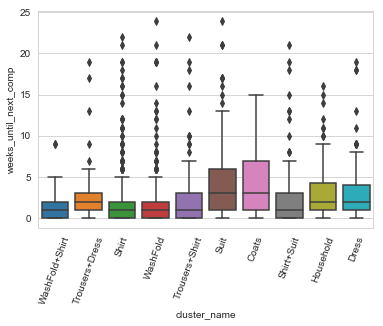

In [174]:
plt.xticks(rotation=70)
sns.categorical.boxplot(data=df_known, x='cluster_name', y='weeks_until_next_comp')

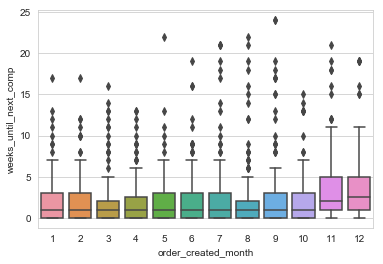

In [175]:
sns.categorical.boxplot(data=df_known, x='order_created_month', y='weeks_until_next_comp')

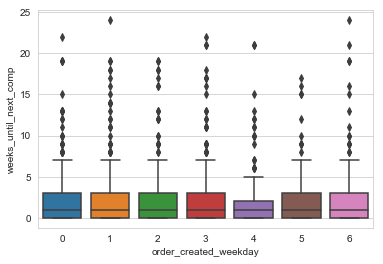

In [176]:
sns.categorical.boxplot(data=df_known, x='order_created_weekday', y='weeks_until_next_comp')

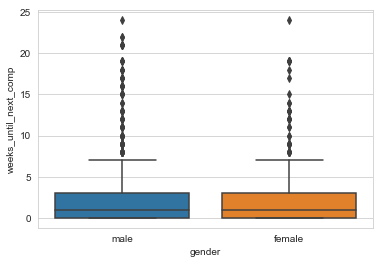

In [177]:
sns.categorical.boxplot(data=df_known, x='gender', y='weeks_until_next_comp')

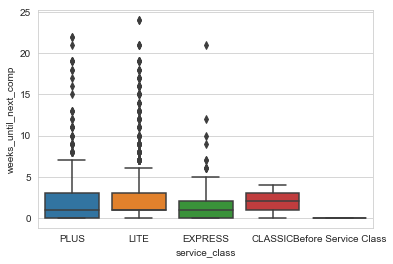

In [178]:
sns.categorical.boxplot(data=df_known, x='service_class', y='weeks_until_next_comp')

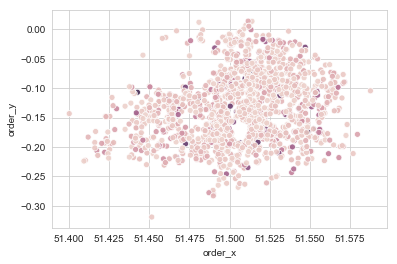

In [179]:
sns.scatterplot(data=df_known, x='order_x', y='order_y', hue='weeks_until_next_comp', alpha=0.9, legend=False)

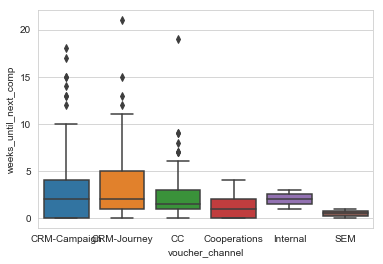

In [180]:
sns.categorical.boxplot(data=df_known, x='voucher_channel', y='weeks_until_next_comp')

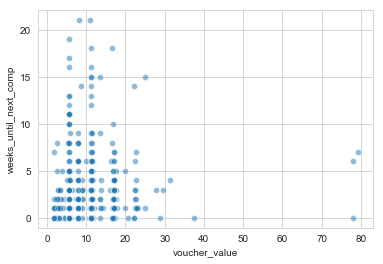

In [181]:
sns.scatterplot(data=df_known.loc[df_known.voucher_value > 0], x='voucher_value', y='weeks_until_next_comp', alpha=0.5, legend=False)

In [182]:
df_known.corr()['weeks_until_next_comp'].sort_values()

num_orders                 -0.251281
completed_orders           -0.251148
churn_factor               -0.217152
recency                    -0.127391
cluster_0.0                -0.095676
rating_missing_items       -0.093847
newsletter_optin           -0.091539
rating_punctuality         -0.089586
product_WF                 -0.081112
cluster_8.0                -0.079023
num_internal_reschedules   -0.072574
product_LA                 -0.070164
cluster_1.0                -0.059941
order_y                    -0.050096
order_created_weekday      -0.042879
aov                        -0.035138
order_num                  -0.021616
cluster_7.0                -0.020629
delay_mins_PU              -0.016371
rating_ironing_quality     -0.008060
rating                     -0.005429
order_x                    -0.000978
delay_mins_DO              -0.000786
cluster_2.0                 0.014648
revenue                     0.014895
referred                    0.015842
cluster_3.0                 0.020284
l

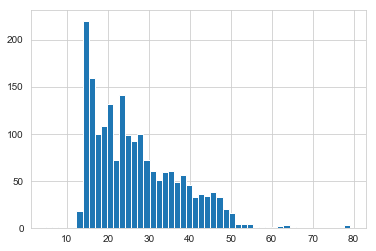

In [183]:
df_known.revenue_brutto.hist(bins=50)

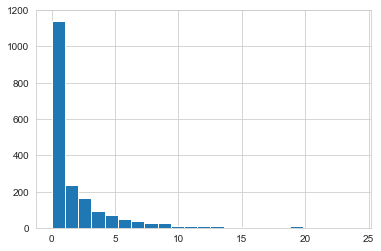

In [184]:
df_known.weeks_until_next_comp.hist(bins=df_known.weeks_until_next_comp.nunique())

In [185]:
df_known.shape

(1929, 90)

# Predictions

In [186]:
feats = ['gender', 'revenue_brutto', 'weeks_since_last_comp',
        'order_created_month'] + df_known.columns[-10:].tolist()
feats

['gender',
 'revenue_brutto',
 'weeks_since_last_comp',
 'order_created_month',
 'cluster_0.0',
 'cluster_1.0',
 'cluster_2.0',
 'cluster_3.0',
 'cluster_4.0',
 'cluster_5.0',
 'cluster_6.0',
 'cluster_7.0',
 'cluster_8.0',
 'cluster_9.0']

In [187]:
# features
df_feats = df_known[['weeks_until_next_comp'] + feats]

df_feats['gender'] = df_feats.gender.map({'male': -1, 'female': 1}).fillna(0)

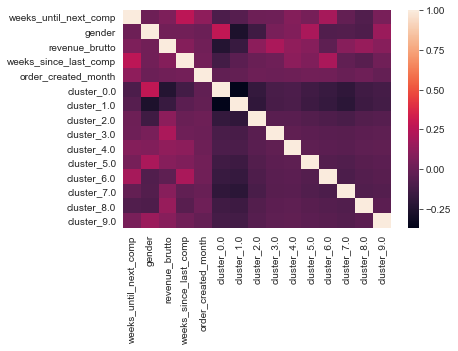

In [188]:
sns.heatmap(df_feats.corr())

In [189]:
X = df_feats.iloc[:, 1:].values
y = df_feats.iloc[:, 0].values
n_classes =  df_feats.iloc[:, 0].nunique()
n_classes

23

In [190]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
y_norm = y.reshape(-1,1)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.25, random_state=42)

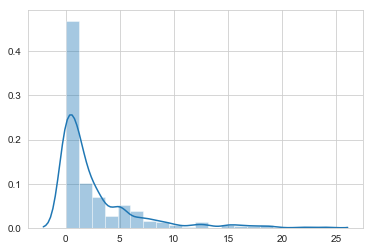

In [192]:
sns.distplot(y_test, bins=20)

In [193]:
log_reg = linear_model.LogisticRegression(class_weight='balanced').fit(X_train, y_train)
print('train', log_reg.score(X_train, y_train), 'test', log_reg.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_train, log_reg.predict(X_train).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))
acc = metrics.accuracy_score(y_test, log_reg.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

train 0.170124481328 test 0.184265010352
17.012%
18.427%


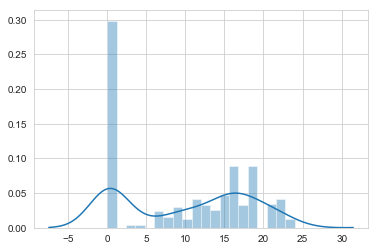

In [194]:
sns.distplot(log_reg.predict(X_test), bins=20)

Text(34,0.5,'True')

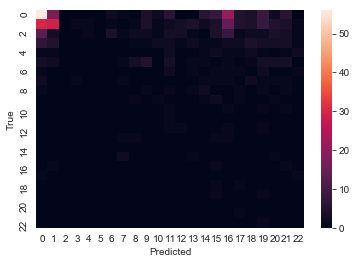

In [195]:
sns.heatmap(metrics.confusion_matrix(y_test, log_reg.predict(X_test).reshape(-1,1)))
plt.xlabel('Predicted')
plt.ylabel('True')

In [196]:
lin_reg = linear_model.SGDRegressor().fit(X_train, y_train)
print('train', lin_reg.score(X_train, y_train), 'test', lin_reg.score(X_test, y_test)) 

train 0.121823112305 test 0.089828886427


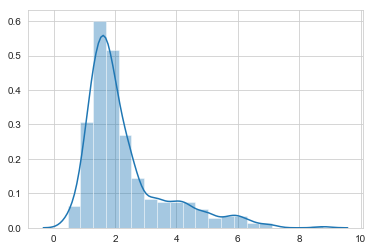

In [197]:
sns.distplot(lin_reg.predict(X_test), bins=20)

Text(34,0.5,'True')

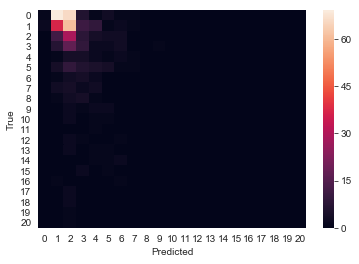

In [198]:
sns.heatmap(metrics.confusion_matrix(y_test, lin_reg.predict(X_test).round()))
plt.xlabel('Predicted')
plt.ylabel('True')

In [137]:
sup = svm.SVC(class_weight='balanced', verbose=True, gamma='auto').fit(X_train, y_train)
print('train', sup.score(X_train, y_train), 'test', sup.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_test, sup.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

[LibSVM]train 0.151014274981 test 0.0720720720721
7.207%


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=40).fit(X_train, y_train) 
neigh.score(X_test, y_test)
print('train', neigh.score(X_train, y_train), 'test', neigh.score(X_test, y_test))
acc = metrics.f1_score(y_test, neigh.predict(X_test), average='weighted')
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
frst = RandomForestClassifier(n_estimators=200, max_depth=4, class_weight='balanced').fit(X_train, y_train)
print('train', frst.score(X_train, y_train), 'test', frst.score(X_test, y_test))
acc = metrics.accuracy_score(y_test, frst.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), random_state=1, max_iter=1000, 
                    learning_rate_init=0.001, verbose=True, batch_size=1, alpha=0.9).fit(X_train, y_train)
print('train', mlp.score(X_train, y_train), 'test', mlp.score(X_test, y_test))
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)
acc = metrics.accuracy_score(y_test, mlp.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
sns.heatmap(metrics.confusion_matrix(y_test, mlp.predict(X_test).reshape(-1,1)))

In [ ]:
bys = linear_model.BayesianRidge().fit(X_train, y_train)
print('train', bys.score(X_train, y_train), 'test', bys.score(X_test, y_test))

In [ ]:
bys.predict(X_test)

In [ ]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full")